In [1]:
"""
Authors:
Mihir Upasani (mu2047@nyu.edu)
Shivani Gawande (sg6630@nyu.edu)
Fabiha Khalid
"""
import time

import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm


class Basics():

    def __init__(self, model, optimizer, schedule, criterion, training_dl, testing_dl, modelName):
        self.model = model
        self.optimizer = optimizer
        self.schedule = schedule
        self.criterion = criterion
        self.device = torch.device(
            'cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.trainingHistory = {
            'accuracy': [],
            'loss': [],
        }
        self.testingHistory = {
            'accuracy': [],
            'loss': [],
        }
        self.validationHistory = {
            'accuracy': [],
            'loss': [],
        }
        self.trainingDataLoader = training_dl
        self.testingDataLoader = testing_dl
        self.modelName = modelName

    def __calculateAccuracy(self, y_pred, y):
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
        return acc

    def __getTime(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def _countParameters(self):
        total_params = 0
        for name, parameter in self.model.named_parameters():
            params = parameter.numel()
            total_params += params
        return total_params

    def _trainModel(self, epoch):
        """
        Abstraction layer for training steps
        1. Make predictions
        2. Calculate loss, accuracy
        3. Propogate loss backwards and update weights
        4. Record statistics, i.e loss, accuracy and time per epoch
        """

        # To indicate model in training phase
        # Will also turn on dropout in case we use it
        self.model.train()

        epoch_loss = 0
        epoch_acc = 0

        with tqdm(self.trainingDataLoader) as tqdmObject:

            startTime = time.time()
            for (x, y) in tqdmObject:
                tqdmObject.set_description(desc=f"Epoch {epoch+1}")
                x = x.to(self.device)
                y = y.to(self.device)

                self.optimizer.zero_grad()

                # Step 1
                y_pred = self.model(x)

                # Step 2
                loss = self.criterion(y_pred, y)
                acc = self.__calculateAccuracy(y_pred, y)

                # Step 3
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                epoch_loss += loss.item()
                epoch_acc += acc.item()
                tqdmObject.set_postfix(accuracy=epoch_acc/len(self.trainingDataLoader),
                                       loss=epoch_loss/len(self.trainingDataLoader))
            # if self.schedule:
            #     self.schedule.step()
            endTime = time.time()

        trainingMinutes, trainingSeconds = self.__getTime(startTime, endTime)
        trainingSeconds += 60 * trainingMinutes
        return epoch_acc/len(self.trainingDataLoader), epoch_loss/len(self.trainingDataLoader), trainingSeconds

    def _evaluateModel(self):
        """
        Abstraction layer for validation steps
        1. Make predictions
        2. Calculate loss, accuracy
        3. Record statistics, i.e loss, accuracy and time per epoch
        """

        # To indicate model in training phase
        # Will also turn on dropout in case we use it
        self.model.eval()

        epoch_loss = 0
        epoch_acc = 0

        with torch.no_grad():
            for (x, y) in self.testingDataLoader:

                x = x.to(self.device)
                y = y.to(self.device)

                # Step 1
                y_pred = self.model(x)

                # Step 2
                loss = self.criterion(y_pred, y)
                acc = self.__calculateAccuracy(y_pred, y)

                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_acc/len(self.testingDataLoader), epoch_loss/len(self.testingDataLoader)

    def trainEpochs(self, epochs=10, plot_results=True):
        """
        Will build more control into it, for now keeping it limited to 

        epochs: how many epochs to train for
        validate: do we even have a validation dataset
        plot_results: whether to plot training, testing and validation losses, accuracies 
        """

        for epoch in range(epochs):
            startTime = time.time()
            trainingAccuracy, trainingLoss, trainingSeconds = self._trainModel(
                epoch)
            testingAccuracy, testingLoss = self._evaluateModel()
            endTime = time.time()
            self.schedule.step(trainingAccuracy)
            epochMinutes, epochSeconds = self.__getTime(startTime, endTime)
            epochSeconds += epochMinutes*60
            print("TrainingLoss:%.2f|TrainingAccuracy:%.2f|EpochTime:%.2fs|TestingLoss:%.2f|TestingAccuracy:%.2f\n" % (
                trainingLoss, trainingAccuracy*100, epochSeconds, testingLoss, testingAccuracy*100))

            self.trainingHistory["loss"].append(trainingLoss)
            self.trainingHistory["accuracy"].append(trainingAccuracy)

            self.testingHistory["loss"].append(testingLoss)
            self.testingHistory["accuracy"].append(testingAccuracy)

        if plot_results:

            X = np.arange(1, epochs+1)

            plt.figure(1)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.plot(X, self.trainingHistory['loss'], label='train_loss')
            plt.plot(X, self.testingHistory['loss'], label='test_loss')
            plt.legend()
            #plt.savefig("./outputs/" + self.modelName + "LossVsEpochs.jpg")

            plt.figure(2)
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.plot(
                X, self.trainingHistory['accuracy'], label='train_acc')
            plt.plot(
                X, self.testingHistory['accuracy'], label='test_acc')
            plt.legend()
            #plt.savefig("./outputs/" + self.modelName + "AccVsEpochs.jpg")

In [2]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear1 = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, kernel_size=3):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, kernel_size))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet18_mod():
    return ResNet(BasicBlock, [2, 1, 1, 1])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")  # PyTorch v0.4.0
    net = ResNet34().to(device)
    summary(net, (3, 28, 28))
    # y = net(torch.randn(1, 3, 32, 32))
    # print(y.size())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./.data/cifar-10-python.tar.gz to ./.data
Files already downloaded and verified
Model has 4977226 parameters
You have 22774 left!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12      

Epoch 1: 100%|██████████| 1563/1563 [00:37<00:00, 41.38it/s, accuracy=0.45, loss=1.5]
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


TrainingLoss:1.50|TrainingAccuracy:45.02|EpochTime:39.00s|TestingLoss:1.23|TestingAccuracy:56.07



Epoch 2: 100%|██████████| 1563/1563 [00:36<00:00, 42.62it/s, accuracy=0.611, loss=1.09]


TrainingLoss:1.09|TrainingAccuracy:61.13|EpochTime:38.00s|TestingLoss:1.04|TestingAccuracy:63.46



Epoch 3: 100%|██████████| 1563/1563 [00:36<00:00, 42.60it/s, accuracy=0.679, loss=0.914]


TrainingLoss:0.91|TrainingAccuracy:67.90|EpochTime:38.00s|TestingLoss:0.88|TestingAccuracy:69.29



Epoch 4: 100%|██████████| 1563/1563 [00:36<00:00, 42.55it/s, accuracy=0.719, loss=0.799]


TrainingLoss:0.80|TrainingAccuracy:71.94|EpochTime:38.00s|TestingLoss:0.82|TestingAccuracy:71.51



Epoch 5: 100%|██████████| 1563/1563 [00:36<00:00, 42.56it/s, accuracy=0.755, loss=0.701]


TrainingLoss:0.70|TrainingAccuracy:75.55|EpochTime:38.00s|TestingLoss:0.79|TestingAccuracy:73.87



Epoch 6: 100%|██████████| 1563/1563 [00:36<00:00, 42.41it/s, accuracy=0.779, loss=0.641]


TrainingLoss:0.64|TrainingAccuracy:77.94|EpochTime:38.00s|TestingLoss:0.65|TestingAccuracy:77.99



Epoch 7: 100%|██████████| 1563/1563 [00:36<00:00, 42.56it/s, accuracy=0.797, loss=0.585]


TrainingLoss:0.58|TrainingAccuracy:79.70|EpochTime:38.00s|TestingLoss:0.59|TestingAccuracy:79.97



Epoch 8: 100%|██████████| 1563/1563 [00:37<00:00, 42.23it/s, accuracy=0.813, loss=0.545]


TrainingLoss:0.55|TrainingAccuracy:81.27|EpochTime:38.00s|TestingLoss:0.56|TestingAccuracy:81.21



Epoch 9: 100%|██████████| 1563/1563 [00:36<00:00, 42.34it/s, accuracy=0.826, loss=0.507]


TrainingLoss:0.51|TrainingAccuracy:82.60|EpochTime:38.00s|TestingLoss:0.55|TestingAccuracy:81.70



Epoch 10: 100%|██████████| 1563/1563 [00:36<00:00, 42.30it/s, accuracy=0.834, loss=0.481]


TrainingLoss:0.48|TrainingAccuracy:83.41|EpochTime:38.00s|TestingLoss:0.56|TestingAccuracy:81.77



Epoch 11: 100%|██████████| 1563/1563 [00:37<00:00, 42.18it/s, accuracy=0.843, loss=0.455]


TrainingLoss:0.45|TrainingAccuracy:84.35|EpochTime:38.00s|TestingLoss:0.52|TestingAccuracy:83.29



Epoch 12: 100%|██████████| 1563/1563 [00:36<00:00, 42.37it/s, accuracy=0.853, loss=0.427]


TrainingLoss:0.43|TrainingAccuracy:85.32|EpochTime:38.00s|TestingLoss:0.51|TestingAccuracy:83.34



Epoch 13: 100%|██████████| 1563/1563 [00:36<00:00, 42.50it/s, accuracy=0.862, loss=0.404]


TrainingLoss:0.40|TrainingAccuracy:86.18|EpochTime:38.00s|TestingLoss:0.47|TestingAccuracy:84.64



Epoch 14: 100%|██████████| 1563/1563 [00:36<00:00, 42.34it/s, accuracy=0.868, loss=0.39]


TrainingLoss:0.39|TrainingAccuracy:86.77|EpochTime:38.00s|TestingLoss:0.44|TestingAccuracy:84.70



Epoch 15: 100%|██████████| 1563/1563 [00:36<00:00, 42.44it/s, accuracy=0.87, loss=0.378]


TrainingLoss:0.38|TrainingAccuracy:87.04|EpochTime:38.00s|TestingLoss:0.48|TestingAccuracy:84.33



Epoch 16: 100%|██████████| 1563/1563 [00:36<00:00, 42.35it/s, accuracy=0.879, loss=0.355]


TrainingLoss:0.36|TrainingAccuracy:87.91|EpochTime:38.00s|TestingLoss:0.43|TestingAccuracy:85.23



Epoch 17: 100%|██████████| 1563/1563 [00:36<00:00, 42.41it/s, accuracy=0.884, loss=0.337]


TrainingLoss:0.34|TrainingAccuracy:88.43|EpochTime:38.00s|TestingLoss:0.47|TestingAccuracy:84.63



Epoch 18: 100%|██████████| 1563/1563 [00:36<00:00, 42.37it/s, accuracy=0.887, loss=0.328]


TrainingLoss:0.33|TrainingAccuracy:88.66|EpochTime:38.00s|TestingLoss:0.44|TestingAccuracy:86.10



Epoch 19: 100%|██████████| 1563/1563 [00:36<00:00, 42.43it/s, accuracy=0.891, loss=0.319]


TrainingLoss:0.32|TrainingAccuracy:89.05|EpochTime:38.00s|TestingLoss:0.37|TestingAccuracy:87.75



Epoch 20: 100%|██████████| 1563/1563 [00:36<00:00, 42.49it/s, accuracy=0.896, loss=0.3]


TrainingLoss:0.30|TrainingAccuracy:89.65|EpochTime:38.00s|TestingLoss:0.41|TestingAccuracy:86.58



Epoch 21: 100%|██████████| 1563/1563 [00:36<00:00, 42.44it/s, accuracy=0.899, loss=0.292]


TrainingLoss:0.29|TrainingAccuracy:89.94|EpochTime:38.00s|TestingLoss:0.43|TestingAccuracy:86.47



Epoch 22: 100%|██████████| 1563/1563 [00:36<00:00, 42.38it/s, accuracy=0.904, loss=0.279]


TrainingLoss:0.28|TrainingAccuracy:90.36|EpochTime:38.00s|TestingLoss:0.40|TestingAccuracy:86.66



Epoch 23: 100%|██████████| 1563/1563 [00:37<00:00, 42.22it/s, accuracy=0.908, loss=0.268]


TrainingLoss:0.27|TrainingAccuracy:90.80|EpochTime:38.00s|TestingLoss:0.39|TestingAccuracy:87.03



Epoch 24: 100%|██████████| 1563/1563 [00:37<00:00, 41.91it/s, accuracy=0.911, loss=0.26]


TrainingLoss:0.26|TrainingAccuracy:91.12|EpochTime:38.00s|TestingLoss:0.38|TestingAccuracy:87.61



Epoch 25: 100%|██████████| 1563/1563 [00:36<00:00, 42.41it/s, accuracy=0.914, loss=0.249]


TrainingLoss:0.25|TrainingAccuracy:91.41|EpochTime:38.00s|TestingLoss:0.37|TestingAccuracy:88.19



Epoch 26: 100%|██████████| 1563/1563 [00:36<00:00, 42.69it/s, accuracy=0.916, loss=0.245]


TrainingLoss:0.25|TrainingAccuracy:91.65|EpochTime:38.00s|TestingLoss:0.37|TestingAccuracy:87.60



Epoch 27: 100%|██████████| 1563/1563 [00:36<00:00, 42.35it/s, accuracy=0.919, loss=0.233]


TrainingLoss:0.23|TrainingAccuracy:91.90|EpochTime:38.00s|TestingLoss:0.41|TestingAccuracy:87.33



Epoch 28: 100%|██████████| 1563/1563 [00:36<00:00, 42.44it/s, accuracy=0.92, loss=0.231]


TrainingLoss:0.23|TrainingAccuracy:91.96|EpochTime:38.00s|TestingLoss:0.35|TestingAccuracy:88.70



Epoch 29: 100%|██████████| 1563/1563 [00:36<00:00, 42.34it/s, accuracy=0.922, loss=0.221]


TrainingLoss:0.22|TrainingAccuracy:92.21|EpochTime:38.00s|TestingLoss:0.34|TestingAccuracy:89.28



Epoch 30: 100%|██████████| 1563/1563 [00:36<00:00, 42.29it/s, accuracy=0.926, loss=0.212]


TrainingLoss:0.21|TrainingAccuracy:92.64|EpochTime:38.00s|TestingLoss:0.39|TestingAccuracy:87.97



Epoch 31: 100%|██████████| 1563/1563 [00:36<00:00, 42.30it/s, accuracy=0.929, loss=0.205]


TrainingLoss:0.21|TrainingAccuracy:92.90|EpochTime:38.00s|TestingLoss:0.38|TestingAccuracy:88.22



Epoch 32: 100%|██████████| 1563/1563 [00:36<00:00, 42.27it/s, accuracy=0.929, loss=0.204]


TrainingLoss:0.20|TrainingAccuracy:92.91|EpochTime:38.00s|TestingLoss:0.37|TestingAccuracy:88.51



Epoch 33: 100%|██████████| 1563/1563 [00:36<00:00, 42.25it/s, accuracy=0.932, loss=0.195]


TrainingLoss:0.20|TrainingAccuracy:93.24|EpochTime:38.00s|TestingLoss:0.33|TestingAccuracy:89.05



Epoch 34: 100%|██████████| 1563/1563 [00:36<00:00, 42.46it/s, accuracy=0.936, loss=0.185]


TrainingLoss:0.18|TrainingAccuracy:93.62|EpochTime:38.00s|TestingLoss:0.36|TestingAccuracy:89.06



Epoch 35: 100%|██████████| 1563/1563 [00:36<00:00, 42.39it/s, accuracy=0.941, loss=0.176]


TrainingLoss:0.18|TrainingAccuracy:94.09|EpochTime:38.00s|TestingLoss:0.36|TestingAccuracy:88.83



Epoch 36: 100%|██████████| 1563/1563 [00:36<00:00, 42.37it/s, accuracy=0.938, loss=0.177]


TrainingLoss:0.18|TrainingAccuracy:93.81|EpochTime:38.00s|TestingLoss:0.34|TestingAccuracy:89.42



Epoch 37: 100%|██████████| 1563/1563 [00:37<00:00, 42.21it/s, accuracy=0.943, loss=0.167]


TrainingLoss:0.17|TrainingAccuracy:94.28|EpochTime:38.00s|TestingLoss:0.34|TestingAccuracy:89.40



Epoch 38: 100%|██████████| 1563/1563 [00:36<00:00, 42.28it/s, accuracy=0.945, loss=0.162]


TrainingLoss:0.16|TrainingAccuracy:94.46|EpochTime:38.00s|TestingLoss:0.34|TestingAccuracy:89.97



Epoch 39: 100%|██████████| 1563/1563 [00:36<00:00, 42.26it/s, accuracy=0.944, loss=0.161]


TrainingLoss:0.16|TrainingAccuracy:94.40|EpochTime:38.00s|TestingLoss:0.37|TestingAccuracy:88.66



Epoch 40: 100%|██████████| 1563/1563 [00:37<00:00, 42.10it/s, accuracy=0.945, loss=0.159]


TrainingLoss:0.16|TrainingAccuracy:94.47|EpochTime:38.00s|TestingLoss:0.36|TestingAccuracy:88.98



Epoch 41: 100%|██████████| 1563/1563 [00:37<00:00, 42.19it/s, accuracy=0.949, loss=0.148]


TrainingLoss:0.15|TrainingAccuracy:94.85|EpochTime:38.00s|TestingLoss:0.34|TestingAccuracy:89.66



Epoch 42: 100%|██████████| 1563/1563 [00:37<00:00, 41.94it/s, accuracy=0.95, loss=0.143]


TrainingLoss:0.14|TrainingAccuracy:95.03|EpochTime:38.00s|TestingLoss:0.32|TestingAccuracy:89.94



Epoch 43: 100%|██████████| 1563/1563 [00:37<00:00, 41.45it/s, accuracy=0.949, loss=0.143]


TrainingLoss:0.14|TrainingAccuracy:94.95|EpochTime:39.00s|TestingLoss:0.38|TestingAccuracy:88.49



Epoch 44: 100%|██████████| 1563/1563 [00:37<00:00, 41.82it/s, accuracy=0.953, loss=0.136]


TrainingLoss:0.14|TrainingAccuracy:95.32|EpochTime:38.00s|TestingLoss:0.37|TestingAccuracy:89.49



Epoch 45: 100%|██████████| 1563/1563 [00:37<00:00, 41.78it/s, accuracy=0.954, loss=0.133]


TrainingLoss:0.13|TrainingAccuracy:95.44|EpochTime:38.00s|TestingLoss:0.33|TestingAccuracy:90.11



Epoch 46: 100%|██████████| 1563/1563 [00:37<00:00, 41.76it/s, accuracy=0.954, loss=0.131]


TrainingLoss:0.13|TrainingAccuracy:95.43|EpochTime:38.00s|TestingLoss:0.36|TestingAccuracy:89.48



Epoch 47: 100%|██████████| 1563/1563 [00:37<00:00, 41.95it/s, accuracy=0.957, loss=0.129]


TrainingLoss:0.13|TrainingAccuracy:95.71|EpochTime:38.00s|TestingLoss:0.35|TestingAccuracy:89.44



Epoch 48: 100%|██████████| 1563/1563 [00:37<00:00, 41.80it/s, accuracy=0.957, loss=0.121]


TrainingLoss:0.12|TrainingAccuracy:95.74|EpochTime:38.00s|TestingLoss:0.37|TestingAccuracy:88.96



Epoch 49: 100%|██████████| 1563/1563 [00:37<00:00, 41.89it/s, accuracy=0.959, loss=0.118]


TrainingLoss:0.12|TrainingAccuracy:95.93|EpochTime:38.00s|TestingLoss:0.35|TestingAccuracy:89.79



Epoch 50: 100%|██████████| 1563/1563 [00:37<00:00, 41.65it/s, accuracy=0.961, loss=0.114]


TrainingLoss:0.11|TrainingAccuracy:96.06|EpochTime:38.00s|TestingLoss:0.33|TestingAccuracy:90.10



Epoch 51: 100%|██████████| 1563/1563 [00:37<00:00, 41.68it/s, accuracy=0.961, loss=0.113]


TrainingLoss:0.11|TrainingAccuracy:96.11|EpochTime:38.00s|TestingLoss:0.37|TestingAccuracy:89.17



Epoch 52: 100%|██████████| 1563/1563 [00:37<00:00, 42.12it/s, accuracy=0.962, loss=0.108]


TrainingLoss:0.11|TrainingAccuracy:96.18|EpochTime:38.00s|TestingLoss:0.36|TestingAccuracy:89.70



Epoch 53: 100%|██████████| 1563/1563 [00:36<00:00, 42.34it/s, accuracy=0.965, loss=0.104]


TrainingLoss:0.10|TrainingAccuracy:96.47|EpochTime:38.00s|TestingLoss:0.34|TestingAccuracy:89.97



Epoch 54: 100%|██████████| 1563/1563 [00:37<00:00, 42.22it/s, accuracy=0.965, loss=0.103]


TrainingLoss:0.10|TrainingAccuracy:96.52|EpochTime:38.00s|TestingLoss:0.33|TestingAccuracy:90.64



Epoch 55: 100%|██████████| 1563/1563 [00:37<00:00, 42.18it/s, accuracy=0.965, loss=0.101]


TrainingLoss:0.10|TrainingAccuracy:96.55|EpochTime:38.00s|TestingLoss:0.32|TestingAccuracy:90.75



Epoch 56: 100%|██████████| 1563/1563 [00:37<00:00, 41.85it/s, accuracy=0.965, loss=0.099]


TrainingLoss:0.10|TrainingAccuracy:96.54|EpochTime:38.00s|TestingLoss:0.35|TestingAccuracy:90.44



Epoch 57: 100%|██████████| 1563/1563 [00:36<00:00, 42.32it/s, accuracy=0.966, loss=0.0981]


TrainingLoss:0.10|TrainingAccuracy:96.59|EpochTime:38.00s|TestingLoss:0.34|TestingAccuracy:90.63



Epoch 58: 100%|██████████| 1563/1563 [00:36<00:00, 42.33it/s, accuracy=0.968, loss=0.094]


TrainingLoss:0.09|TrainingAccuracy:96.77|EpochTime:38.00s|TestingLoss:0.35|TestingAccuracy:90.38



Epoch 59: 100%|██████████| 1563/1563 [00:36<00:00, 42.29it/s, accuracy=0.969, loss=0.0922]


TrainingLoss:0.09|TrainingAccuracy:96.89|EpochTime:38.00s|TestingLoss:0.35|TestingAccuracy:90.37



Epoch 60: 100%|██████████| 1563/1563 [00:36<00:00, 42.32it/s, accuracy=0.969, loss=0.0903]


TrainingLoss:0.09|TrainingAccuracy:96.92|EpochTime:38.00s|TestingLoss:0.35|TestingAccuracy:90.34



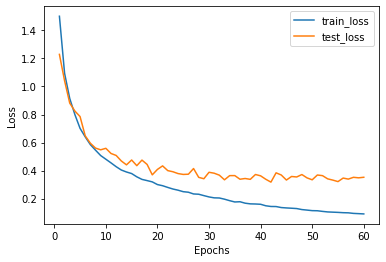

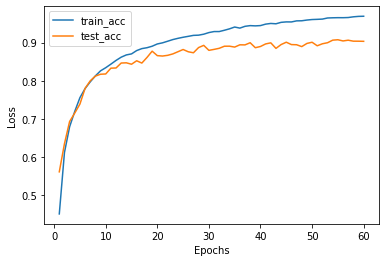

In [3]:
from math import sqrt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary


# Defining constants, based on assignment
OUTPUT_CLASSES = 10
IO_PROCESSES = 2
FLIP_PROBABILITY = 0.5
TRAINING_BATCH_SIZE = 32
TESTING_BATCH_SIZE = 256
EPOCHS = 60
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
ROOT = "./.data"
MAX_PARAMS = 5000000

# Lets start by defning transforms.
# I'm going to assume that transforms are a part of the learning process
# This implies that no transformations will be applied to the testing data
# Except the normalization step obviously
training_transformations = transforms.Compose(
    [
        transforms.RandomCrop(
            size=(32, 32), padding=4),
        transforms.RandomHorizontalFlip(
            FLIP_PROBABILITY),
        transforms.ToTensor()
    ]
)

testing_transformations = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)


def downloadData(ROOT):
    # Now we load training amd testing data
    # Note, this is different to the DataLoader step. That shall come after this
    training_data = datasets.CIFAR10(
        ROOT,
        train=True,
        download=True,
        transform=training_transformations
    )

    testing_data = datasets.CIFAR10(
        ROOT,
        train=False,
        download=True,
        transform=testing_transformations
    )

    return training_data, testing_data


if __name__ == "__main__":

    trainingData, testingData = downloadData(ROOT)

    trainingDataLoader = torch.utils.data.DataLoader(
        dataset=trainingData,
        batch_size=TRAINING_BATCH_SIZE,
        shuffle=True
    )
    testingDataLoader = torch.utils.data.DataLoader(
        dataset=testingData,
        batch_size=TESTING_BATCH_SIZE,
        shuffle=True
    )
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")

    model = ResNet18_mod().to(device)

    modelParams = model.parameters()
    setParams = {
        "params": modelParams,
        "lr": LEARNING_RATE,
        "momentum": MOMENTUM,
        "weight_decay": WEIGHT_DECAY,
        "nesterov": True,
    }

    optimizer = optim.SGD(**setParams)
    # optimizer = optim.Adam(**setParams)
    lossFunction = nn.CrossEntropyLoss()
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, LEARNING_RATE, epochs=EPOCHS,
                                                 steps_per_epoch=len(trainingDataLoader))
    '''sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=0) '''

    trainingAbstraction = Basics(
        model, optimizer, sched, lossFunction, trainingDataLoader, testingDataLoader, modelName="Attempt18")

    parameters = trainingAbstraction._countParameters()
    print(f"Model has {parameters} parameters")
    assert parameters <= MAX_PARAMS
    print(f"You have {MAX_PARAMS-parameters} left!")
    summary(model, (3, 32, 32))

    trainingAbstraction.trainEpochs(EPOCHS)
